In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import os
import numpy as np
import torch

from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


## Set location and object set for YCB Dataset
### YCB Object Indices

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

In [2]:
### Set this to the root of your YCB Dataset
dataset_root = '/media/DataDrive/ycb/YCB_Video_Dataset'

### If you want individual objects, change this to
### a list of the indices you want (see above).
object_list = list(range(1,22))

### Set this to the dataset subset you want
mode = 'test'

## Initalize YCB Dataset

In [3]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer

from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes


output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.IMAGE_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = object_list,
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)


## Initialize Dense Fusion Pose Estimator

In [4]:
from dense_fusion.network import PoseNet, PoseNetGlobal, PoseRefineNet, PoseNetDropout

df_weights = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
df_estimator = PoseNet(num_points = 1000, num_obj = 21)
df_estimator.load_state_dict(torch.load(df_weights, map_location=torch.device('cpu')))
df_estimator.cuda();
df_estimator.eval();

## Set Feature Comparison File Paths

In [5]:
### Set this to the root of your grid featurization
feature_root = '../weights/'

### Set this to your comparison network checkpoint file path
comp_model_checkpoint = '../weights/feature_comparison.pth'

## Initialize the Feature Comparison Network

In [6]:
from se3_distributions.losses.loglik_loss import evaluateFeature
from se3_distributions.models.compare_networks import SigmoidCompareNet, SigmoidNet
from object_pose_utils.utils.interpolation import TetraInterpolation
tetra_interp = TetraInterpolation(2)

feature_key = 'feat_global'
feature_size = 1024

grid_vertices = torch.load(os.path.join(feature_root, 'grid',
    '{}_vertices.pt'.format(dataset.classes[1])))


### Histogram Comparison

grid_features = {}
for object_id in object_list:
    grid_features[object_id] = torch.load(os.path.join(feature_root, 'grid',
        '{}_{}_features.pt'.format(feature_key, dataset.classes[object_id])))

comp_estimator = SigmoidCompareNet(feature_size, 21)
comp_estimator.load_state_dict(torch.load(comp_model_checkpoint))
comp_estimator.cuda();
comp_estimator.eval();

def histogram_comparison(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_estimator, img, points, choose, obj)
    lik_est = evaluateFeature(comp_estimator, obj, feat, grid_features)
    lik_est = to_np(lik_est.flatten())
    lik_est /= lik_est.sum()
    return lik_est, max_q, max_t

## Sample Dataset and Estimate Likelihood Distribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Likelihood of Ground Truth: 0.31578
Likelihood of Estimate: 0.52616


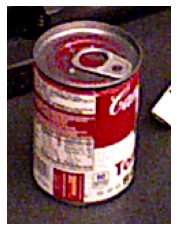

In [13]:
%matplotlib inline 
from object_pose_utils.utils.display import torch2Img
from se3_distributions.utils.evaluation_utils import evaluateDenseFusion

index = np.random.randint(len(dataset))

obj, quat, trans, img, points, choose = dataset[index]
lik_est, q_est, t_est = histogram_comparison(img, points, choose, obj)

tetra_interp.setValues(lik_est)
lik_gt = tetra_interp.smooth(to_np(quat)).item()
lik_out = tetra_interp.smooth(q_est).item()

print('Likelihood of Ground Truth: {:0.5f}'.format(lik_gt))
print('Likelihood of Estimate: {:0.5f}'.format(lik_out))
plt.imshow(torch2Img(img, normalized=True))
plt.axis('off')
plt.show()

## Visualize Distribution 

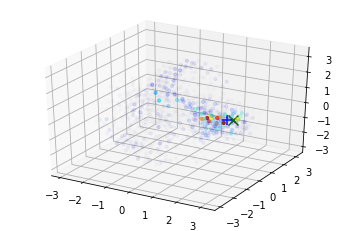

In [14]:
#%matplotlib notebook 

from object_pose_utils.utils.display import scatterSO3, quats2Point
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

scatterSO3(to_np(grid_vertices), lik_est, [to_np(quat)], ax=ax, alims = [0,1], s=10)
gt_pt = quats2Point([to_np(quat)])
est_pt = quats2Point([q_est])
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g',s=100, marker='x')
ax.scatter(est_pt[:,0], est_pt[:,1], est_pt[:,2], c='b',s=100, marker='+')
plt.show()